# Human Activity Detector Model

In [ ]:
# !pip install ultralytics mediapipe --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import joblib

# ultralytics YOLO API
from ultralytics import YOLO

# MediaPipe
import mediapipe as mp

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


E0000 00:00:1760810911.617652      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760810911.676850      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Coba pakai cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Import Dataset

In [4]:
DATA_ROOT = Path("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition")
OUTPUT_DIR = "/kaggle/working"
TRAIN_IMG_DIR = DATA_ROOT / "train"
TEST_IMG_DIR = DATA_ROOT / "test"
TRAIN_CSV = DATA_ROOT / "Training_set.csv"
TEST_CSV = DATA_ROOT / "Testing_set.csv"

EPOCH_AMOUNT = 15

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [5]:
print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

Train samples: 12600
Test samples: 5400


## Importing YOLOv12n

In [6]:
yolo_model = YOLO("yolo12n.pt")

sample_img = str(TRAIN_IMG_DIR / train_df.iloc[0]["filename"])
res = yolo_model.predict(source=sample_img, imgsz=640, conf=0.25, device=0 if torch.cuda.is_available() else "cpu", verbose=False)
print("YOLO inference OK, boxes found:", len(res[0].boxes) if res else 0)

YOLO inference OK, boxes found: 1


In [7]:
# Cell 5: function to get largest-person crop (as image array, not saving)
def get_largest_person_crop(image_path, yolo_model, conf_thresh=0.25):
    results = yolo_model.predict(
        source=str(image_path),
        imgsz=640,
        conf=conf_thresh,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )
    if not results:
        return None
    r = results[0]
    if r.boxes is None or len(r.boxes) == 0:
        return None

    boxes = []
    for b in r.boxes:
        xyxy = b.xyxy.cpu().numpy().flatten().tolist()
        boxes.append(xyxy)
    # choose largest box
    best = max(boxes, key=lambda xyxy: (xyxy[2]-xyxy[0])*(xyxy[3]-xyxy[1]))
    x1, y1, x2, y2 = map(int, best)
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    h, w, _ = img.shape
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2]


In [8]:
# Cell 6: extract mediapipe pose landmarks directly from YOLO crops
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

def extract_pose_from_image(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = pose_detector.process(img_rgb)
    if not res or not res.pose_landmarks:
        return np.zeros(33*4, dtype=np.float32)
    lm = []
    for l in res.pose_landmarks.landmark:
        lm.extend([l.x, l.y, l.z, l.visibility])
    return np.array(lm, dtype=np.float32)


In [9]:
class YOLOCropImageDataset(Dataset):
    def __init__(self, df, img_dir, yolo_model, pose_detector, label_encoder=None, is_train=True, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.yolo_model = yolo_model
        self.pose_detector = pose_detector
        self.le = label_encoder
        self.is_train = is_train
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["filename"]
        crop = get_largest_person_crop(img_path, self.yolo_model)
        if crop is None:
            crop = np.zeros((224,224,3), dtype=np.uint8)
        img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        if self.transform:
            img = self.transform(img)
        if self.is_train:
            y = int(self.le.transform([row["label"]])[0])
            return img, y
        else:
            return img, row["filename"]

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
# Cell 8: prepare datasets
le = LabelEncoder()
le.fit(train_df["label"])
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)), test_size=0.15, stratify=train_df["label"], random_state=42
)
train_sub = train_df.iloc[train_idx].reset_index(drop=True)
val_sub = train_df.iloc[val_idx].reset_index(drop=True)

train_dataset = YOLOCropImageDataset(train_sub, TRAIN_IMG_DIR, yolo_model, pose_detector, le, True, transform_train)
val_dataset = YOLOCropImageDataset(val_sub, TRAIN_IMG_DIR, yolo_model, pose_detector, le, True, transform_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
joblib.dump(le, OUTPUT_DIR + "/label_encoder.pkl")

['/kaggle/working/label_encoder.pkl']

## Using DenseNet

In [12]:
# Cell 12: DenseNet121 fine-tuning on YOLO crops
densenet = models.densenet121(weights='IMAGENET1K_V1')
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, len(le.classes_))
densenet = densenet.to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(densenet.parameters(), lr=1e-4)

def train_epoch(model, loader):
    model.train()
    total_loss, preds, trues = [], [], []
    for x, y in tqdm(loader, desc="Training", unit="batch"):
        x, y = x.to(device), y.to(device)
        optimizer2.zero_grad()
        logits = model(x)
        loss = criterion2(logits, y)
        loss.backward()
        optimizer2.step()

        total_loss.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(y.cpu().numpy())
    return np.mean(total_loss), accuracy_score(trues, preds)

def eval_epoch(model, loader):
    model.eval()
    total_loss, preds, trues = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion2(logits, y)
            total_loss.append(loss.item())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    return np.mean(total_loss), accuracy_score(trues, preds)

best_acc = 0
for epoch in range(0, EPOCH_AMOUNT):
    tr_loss, tr_acc = train_epoch(densenet, train_loader)
    val_loss, val_acc = eval_epoch(densenet, val_loader)
    print(f"[DenseNet] Epoch {epoch:02d} | Train {tr_acc:.3f} | Val {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(densenet.state_dict(), OUTPUT_DIR + "/best_densenet_yolo.pth")


W0000 00:00:1760810925.364943     124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760810925.430923     125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 147MB/s] 
Training: 100%|██████████| 335/335 [07:51<00:00,  1.41s/batch]


[DenseNet] Epoch 00 | Train 0.604 | Val 0.719


Training: 100%|██████████| 335/335 [06:17<00:00,  1.13s/batch]


[DenseNet] Epoch 01 | Train 0.794 | Val 0.751


Training: 100%|██████████| 335/335 [06:10<00:00,  1.11s/batch]


[DenseNet] Epoch 02 | Train 0.865 | Val 0.764


Training: 100%|██████████| 335/335 [06:12<00:00,  1.11s/batch]


[DenseNet] Epoch 03 | Train 0.916 | Val 0.764


Training: 100%|██████████| 335/335 [06:08<00:00,  1.10s/batch]


[DenseNet] Epoch 04 | Train 0.942 | Val 0.753


Training: 100%|██████████| 335/335 [06:12<00:00,  1.11s/batch]


[DenseNet] Epoch 05 | Train 0.964 | Val 0.765


Training: 100%|██████████| 335/335 [06:11<00:00,  1.11s/batch]


[DenseNet] Epoch 06 | Train 0.969 | Val 0.759


Training: 100%|██████████| 335/335 [06:12<00:00,  1.11s/batch]


[DenseNet] Epoch 07 | Train 0.972 | Val 0.749


Training: 100%|██████████| 335/335 [06:08<00:00,  1.10s/batch]


[DenseNet] Epoch 08 | Train 0.976 | Val 0.741


Training: 100%|██████████| 335/335 [06:05<00:00,  1.09s/batch]


[DenseNet] Epoch 09 | Train 0.979 | Val 0.765


Training: 100%|██████████| 335/335 [06:14<00:00,  1.12s/batch]


[DenseNet] Epoch 10 | Train 0.982 | Val 0.741


Training: 100%|██████████| 335/335 [06:05<00:00,  1.09s/batch]


[DenseNet] Epoch 11 | Train 0.977 | Val 0.721


Training: 100%|██████████| 335/335 [06:03<00:00,  1.08s/batch]


[DenseNet] Epoch 12 | Train 0.978 | Val 0.743


Training: 100%|██████████| 335/335 [06:03<00:00,  1.09s/batch]


[DenseNet] Epoch 13 | Train 0.982 | Val 0.743


Training: 100%|██████████| 335/335 [06:06<00:00,  1.10s/batch]


[DenseNet] Epoch 14 | Train 0.983 | Val 0.752


=== YOLO Crops + DenseNet Classification Report ===
                    precision    recall  f1-score   support

           calling       0.81      0.72      0.76       126
          clapping       0.72      0.79      0.75       126
           cycling       0.93      0.92      0.92       126
           dancing       0.79      0.66      0.72       126
          drinking       0.81      0.83      0.82       126
            eating       0.74      0.88      0.80       126
          fighting       0.78      0.80      0.79       126
           hugging       0.80      0.81      0.81       126
          laughing       0.76      0.80      0.78       126
listening_to_music       0.89      0.71      0.79       126
           running       0.74      0.82      0.77       126
           sitting       0.54      0.60      0.57       126
          sleeping       0.73      0.87      0.79       126
           texting       0.84      0.67      0.74       126
      using_laptop       0.70      0.61      0.

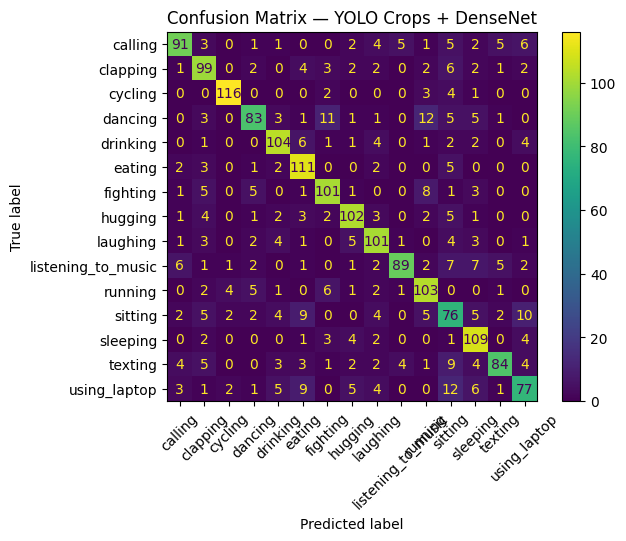

In [13]:
# Cell 14: evaluation — classification report & confusion matrix (YOLO crops + ResNet)
# reload best ResNet model
densenet_best = models.densenet121(weights=None)
num_features = densenet_best.classifier.in_features
densenet_best.classifier = nn.Linear(num_features, len(le.classes_))
state_dict = torch.load(OUTPUT_DIR + "/best_densenet_yolo.pth", map_location=device)
densenet_best.load_state_dict(state_dict)
densenet_best = densenet_best.to(device)
densenet_best.eval()

y_true_res, y_pred_res = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = densenet_best(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_res.extend(preds)
        y_true_res.extend(y.cpu().numpy())

print("=== YOLO Crops + DenseNet Classification Report ===")
print(classification_report(y_true_res, y_pred_res, target_names=le.classes_, zero_division=0))

cm_res = confusion_matrix(y_true_res, y_pred_res)
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=le.classes_)
disp_res.plot(xticks_rotation=45)
plt.title("Confusion Matrix — YOLO Crops + DenseNet")
plt.show()
